Using a pretrained GNN based model as fingerprint for our molecular pairs

In [ ]:
#!pip install umap-learn

In [ ]:
!pip install rdkit-pypi
!pip install dgl

     |████████████████████████████████| 22.7 MB 1.5 MB/s 
     |████████████████████████████████| 4.4 MB 4.7 MB/s 


In [ ]:
!pip install dgl-cu101

     |████████████████████████████████| 36.2 MB 310 kB/s 


In [ ]:
# Import the main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import subprocess
import os
import  sys
# Evalute on the RC data
# Import evaluation libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from rdkit import Chem
from rdkit.Chem import AllChem

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [167]:
# Training co-crystal data

cocrystals= pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/data_complete/csd_training_set.csv', encoding='latin1') 
train_cocrystal_smiles = set(np.concatenate([cocrystals.smiles1.values, cocrystals.smiles2.values]))
print(len(train_cocrystal_smiles))

# Validation co-crystal data
validation_data = pd.read_csv('/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/data_complete/cocrystal_screening_validation_database.csv', encoding='latin1')
validation_data_smiles = set(np.concatenate([validation_data.smiles1.values, validation_data.smiles2.values]))
print(len(validation_data_smiles))

4343
744


# Molecular graph embeddings

In [173]:
def get_representation(dataset):
    """ Given the smiles of a validation dataset convert it to fingerprint
     representation """  
    wrong_smiles = [] 
    for i in dataset['smiles1'].values:
        if Chem.MolFromSmiles(i) == None:
            print('Wrong smiles1', i)
            wrong_smiles.append(i)
    for i in dataset['smiles2'].values:
        if Chem.MolFromSmiles(i) == None:
            print('Wrong smiles2', i)
            wrong_smiles.append(i)
    pd.DataFrame(wrong_smiles, columns=['wrong smiles']).to_csv('wrong_smiles.csv')
    dataset = dataset[~dataset.Smiles1.isin(wrong_smiles)]
    dataset = dataset[~dataset.Smiles2.isin(wrong_smiles)]
    df = pd.concat([pd.DataFrame(dataset.Cocrystal.values,columns=['Cocrystal']) , 
    pd.DataFrame(dataset['smiles1'].values, columns=['smiles1'] ),
    pd.DataFrame(dataset['smiles2'].values, columns=['smiles2'])], axis=1)
    return df, wrong_smiles

def smiles2txt(dataset, smiles1_file, smiles2_file):  
    ''' reading the smiles from the csv file and saves them in txt file in order to get the 
    graph embendings from each smile'''

    with open(os.path.join("/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/gnn", smiles1_file), 'w') as f:
        for item in dataset['smiles1'].values:
            f.write("%s\n" % item)

    with open(os.path.join("/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/gnn", smiles2_file), 'w') as f:
        for item in dataset['smiles2'].values:
            f.write("%s\n" % item)

In [174]:
!cp '/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/dgl-lifesci/python/main.py' '/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/gnn'

In [175]:
smiles2txt(validation_data, 'smiles1.txt','smiles2.txt')

In [176]:
!wc -l /content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/gnn/smiles2.txt

2427 /content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/gnn/smiles2.txt


In [177]:
%%writefile /tmp/dgl_lifesci.sh
#!/usr/bin/env bash

# This bash script is simply a useful utility for running dgl-lifesci main script
# without having to have long path names and so on

export COCRYSTAL_PATH="/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals"
export DGLLIFESCI=$COCRYSTAL_PATH/dgl-lifesci/python

PYTHONPATH=$DGLLIFESCI python3 $DGLLIFESCI/main.py "$@"

Overwriting /tmp/dgl_lifesci.sh


In [178]:
!chmod +x /tmp/dgl_lifesci.sh

In [179]:
GNN_DIR = "/content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/gnn/"

In [180]:
!/tmp/dgl_lifesci.sh -fi {GNN_DIR}/smiles1.txt -m gin_supervised_masking -o {GNN_DIR}/results1
!/tmp/dgl_lifesci.sh -fi {GNN_DIR}/smiles2.txt -m gin_supervised_masking -o {GNN_DIR}/results2

Using backend: pytorch
Directory /content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/gnn//results1 already exists.
Pretrained model loaded
Processing batch 1/10
Processing batch 2/10
Processing batch 3/10
Processing batch 4/10
Processing batch 5/10
Processing batch 6/10
Processing batch 7/10
Processing batch 8/10
Processing batch 9/10
Processing batch 10/10
Using backend: pytorch
Directory /content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/gnn//results2 already exists.
Pretrained model loaded
Processing batch 1/10
Processing batch 2/10
Processing batch 3/10
Processing batch 4/10
Processing batch 5/10
Processing batch 6/10
Processing batch 7/10
Processing batch 8/10
Processing batch 9/10
Processing batch 10/10


In [181]:
valid1 = np.load(f'{GNN_DIR}/results1/mol_emb.npy')
valid2 = np.load(f'{GNN_DIR}/results2/mol_emb.npy')
print(valid1.shape)
print(valid2.shape)
validation_set = pd.concat([pd.DataFrame(valid1), pd.DataFrame(valid2)],axis=1)

(2427, 300)
(2427, 300)


In [365]:
val_label = validation_data['Co-crystal']
val_data = validation_set
val_data_label=val_label

In [78]:
smiles2txt(cocrystals, 'csd_smiles1.txt','csd_smiles2.txt')

!/tmp/dgl_lifesci.sh -fi {GNN_DIR}/csd_smiles1.txt -m gin_supervised_masking -o {GNN_DIR}/csd_results1
!/tmp/dgl_lifesci.sh -fi {GNN_DIR}/csd_smiles2.txt -m gin_supervised_masking -o {GNN_DIR}/csd_results2

Using backend: pytorch
Directory /content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/gnn//csd_results1 already exists.
Pretrained model loaded
Processing batch 1/28
Processing batch 2/28
Processing batch 3/28
Processing batch 4/28
Processing batch 5/28
Processing batch 6/28
Processing batch 7/28
Processing batch 8/28
Processing batch 9/28
Processing batch 10/28
Processing batch 11/28
Processing batch 12/28
Processing batch 13/28
Processing batch 14/28
Processing batch 15/28
Processing batch 16/28
Processing batch 17/28
Processing batch 18/28
Processing batch 19/28
Processing batch 20/28
Processing batch 21/28
Processing batch 22/28
Processing batch 23/28
Processing batch 24/28
Processing batch 25/28
Processing batch 26/28
Processing batch 27/28
Processing batch 28/28
Using backend: pytorch
Directory /content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/gnn//csd_results2 already exists.
Pretrained model loaded
Processing batch 1/28
Processing batch 2/28
Process

In [79]:
#smiles2txt(cocrystals1, 'csd_smiles1.txt','csd_smiles2.txt')

!/tmp/dgl_lifesci.sh -fi {GNN_DIR}/csd_smiles1.txt -m gin_supervised_masking -o {GNN_DIR}/csd_results1
!/tmp/dgl_lifesci.sh -fi {GNN_DIR}/csd_smiles2.txt -m gin_supervised_masking -o {GNN_DIR}/csd_results2

Using backend: pytorch
Directory /content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/gnn//csd_results1 already exists.
Pretrained model loaded
Processing batch 1/28
Processing batch 2/28
Processing batch 3/28
Processing batch 4/28
Processing batch 5/28
Processing batch 6/28
Processing batch 7/28
Processing batch 8/28
Processing batch 9/28
Processing batch 10/28
Processing batch 11/28
Processing batch 12/28
Processing batch 13/28
Processing batch 14/28
Processing batch 15/28
Processing batch 16/28
Processing batch 17/28
Processing batch 18/28
Processing batch 19/28
Processing batch 20/28
Processing batch 21/28
Processing batch 22/28
Processing batch 23/28
Processing batch 24/28
Processing batch 25/28
Processing batch 26/28
Processing batch 27/28
Processing batch 28/28
Using backend: pytorch
Directory /content/drive/MyDrive/cocrystal_design-master/ccdc_ml_cocrystals/gnn//csd_results2 already exists.
Pretrained model loaded
Processing batch 1/28
Processing batch 2/28
Process

In [80]:
cocrystal1= np.load(f'{GNN_DIR}/csd_results1/mol_emb.npy')
cocrystal2=np.load(f'{GNN_DIR}/csd_results2/mol_emb.npy')
df_train = pd.concat([pd.DataFrame(cocrystal1), pd.DataFrame(cocrystal2)],axis=1)

# Deep one class

In [185]:
# Import the neural network architectures and libraries
%cd /content/drive/My Drive/cocrystal_design-master/models/deep_one_class
%cd src/set_transformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
from modules import SAB, PMA, ISAB
import tqdm
import logging
import random

/content/drive/.shortcut-targets-by-id/1OfY2PW77dTgP9czKrwWu5DOIAtVGbYk4/cocrystal_design-master/models/deep_one_class
/content/drive/.shortcut-targets-by-id/1OfY2PW77dTgP9czKrwWu5DOIAtVGbYk4/cocrystal_design-master/models/deep_one_class/src/set_transformer


In [186]:

#torch.cuda.empty_cache() 
% cd ..
from base.torchvision_dataset import TorchvisionDataset

from utils.config import Config
import deepSVDD
from base.base_net import BaseNet

/content/drive/.shortcut-targets-by-id/1OfY2PW77dTgP9czKrwWu5DOIAtVGbYk4/cocrystal_design-master/models/deep_one_class/src


In [187]:
class Pairs_Dataset(TorchvisionDataset):

    def __init__(self, root: str, train_idx=None, test_idx=None, data=None):
        super().__init__(root)
        ## Loading the train set
        self.train_set = Pairs(root=self.root, train=True, data=data)
        if train_idx is not None:
          self.train_set = Subset(self.train_set, train_idx)
        ## Loading the test set
        self.test_set = Pairs(root=self.root, train=False, data=data)
        if test_idx is not None:
            self.test_set = Subset(self.test_set, test_idx)

class Pairs(Dataset):

    def __init__(self, root, train, data=None):
        super(Pairs, self).__init__()

        self.train = train

        if train:
          # Setup the train dataset
          self.data=data.values.astype('f')
          self.labels=np.zeros(self.data.shape[0])

        else:
          # Setup the test dataset
          self.data = pd.DataFrame(val_data.values).values.astype('f')
          self.labels = np.abs(pd.DataFrame(val_data_label.values).values - 1)


    # This is used to return a single datapoint
    def __getitem__(self, index):
        return self.data[index], self.labels[index], index

    # For Pytorch to know how many datapoints are in the dataset
    def __len__(self):
        return len(self.data)
        return self.decoder(self.encoder(x))

In [188]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


In [193]:
class PairsEncoder(nn.Module):

    def __init__(self,proba=0.1):
        super().__init__()
        self.rep_dim = 50
        self.seq = nn.Sequential(SAB(dim_in=300, dim_out=150, num_heads=5),
                                 nn.Dropout(p=proba),
            SAB(dim_in=150, dim_out=50, num_heads=5),
        PMA(dim=50, num_heads=2, num_seeds=1))

    def forward(self, inp):
      x = torch.split(inp, 300, dim=1)     
      x= torch.stack(x).transpose(0,1)
      x = self.seq(x).squeeze()
      return x.view(inp.size(0), -1)


class PairsAutoEncoder(nn.Module):
    def __init__(self, proba=0.1):
        super().__init__()
        self.encoder = PairsEncoder(proba)
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential( nn.Linear(in_features=50, out_features=300), nn.LeakyReLU(),
        nn.Linear(in_features=300, out_features=600))
        self.decoder.apply(init_weights)
    def forward(self, x):
        return self.decoder(self.encoder(x)).squeeze()

In [194]:
def build_autoencoder(net_name):
    return PairsAutoEncoder()

def build_network(net_name):  
  return PairsEncoder()

torch.manual_seed(0)#
deepSVDD.build_network = build_network
deepSVDD.build_autoencoder = build_autoencoder

In [195]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
log_file = './log.txt'
file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [196]:
cfg = Config({'normal_class': 1, 
              'n_jobs_dataloader': 0, 
              'ae_weight_decay': 0.0005, 
              'ae_batch_size': 200, 
              'ae_lr_milestone': (50,), 
              'ae_n_epochs': 5, 
              'ae_lr': 0.0001,
              'ae_optimizer_name': 'adam', 
              'pretrain': True, 
              'weight_decay': 5e-07,
              'batch_size': 200, 
              'lr_milestone': (50,),
              'n_epochs': 5, 
              'lr': 0.0001, 
              'optimizer_name': 'adam', 
              'seed': 0, 
              'device': 'cuda', 
              'nu': 0.05, 
              'objective':  'one-class', 
              'load_model': None, 
              'load_config': None,'dataset_name': 'cocry', 'net_name': 'CocryNet'} )

In [197]:
dataset_name = cfg.settings['dataset_name']
normal_class = cfg.settings['normal_class']
net_name = cfg.settings['net_name']
n_jobs_dataloader = 0

dataset = Pairs_Dataset('', data= df_train.iloc[:, :] )#df.iloc[:1600, 1:])  #load_dataset(dataset_name, data_path, normal_class) KatPair(df1_scaled, df2_scaled) #

In [198]:
def set_seed():
  seed = cfg.settings.get('seed', 0)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [199]:
set_seed()
deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
deep_SVDD.set_network(net_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [200]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [203]:
deep_SVDD.pretrain(dataset,
                   optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=1e-3,
                   n_epochs = 100 , 
                   lr_milestones=(100,),
                   batch_size= 32,
                   weight_decay= 0.00001,
                   device=device,
                   n_jobs_dataloader=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/100	 Time: 2.432	 Loss: 17.52518116
INFO:root:  Epoch 2/100	 Time: 2.451	 Loss: 10.83926573
INFO:root:  Epoch 3/100	 Time: 2.408	 Loss: 9.19766824
INFO:root: 

In [108]:
#!mkdir '/content/drive/MyDrive/checkpoints/'

In [ ]:
# Save the deepSVDD model
pth_path = ('/content/drive/MyDrive/checkpoints/model_100_1e-3_32_1e-05_gnn.pth') 
deep_SVDD.save_model(pth_path)
deep_SVDD.ae_net

AUC per dataset

In [368]:
from optim.ae_trainer import bidirectional_score

In [370]:
def ae_score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.ae_net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        scores = bidirectional_score(X, y)
    return scores

In [371]:
valid=pd.concat([validation_data.Dataset[validation_set.index], validation_set], axis=1)
set(valid.Dataset)

{'(des)loratadine',
 'Dicarboxylic acids',
 'H-bond synthons dataset',
 'Linezolid',
 'MOP',
 'Phenolic acids',
 'Propyphenazone',
 'artemisin',
 'ibuprofen',
 'meps',
 'pahs',
 'praziquantel'}

In [372]:
# Evaluate on datasets
def evaluate(name):
  df = valid[valid.Dataset == name]
  val_label = validation_data['Co-crystal']
  df_label = val_label.loc[df.index]
  roc_auc = roc_auc_score(df_label.values, -1*ae_score(deep_SVDD, df.iloc[:,1:].values).cpu().detach().numpy())
  print(name, round(roc_auc,2))

In [373]:
dataset_names=['MOP', 'ibuprofen', 'Linezolid', 'meps', 'Propyphenazone', '(des)loratadine']

for name in set(valid.Dataset):
  evaluate(name)

meps 0.75
H-bond synthons dataset 0.74
pahs 0.12
praziquantel 0.56
Propyphenazone 0.87
artemisin 0.91
(des)loratadine 0.71
Linezolid 0.79
Phenolic acids 0.6
ibuprofen 0.68
Dicarboxylic acids 0.76
MOP 0.81


AUC per API

In [374]:
# Evaluate per API
api_list= list(set(validation_data[validation_data.Dataset=='meps'][['name1']].values.ravel()))
meps_df = pd.concat([validation_data[validation_data.Dataset=='meps']['name1'], valid[valid.Dataset == 'meps']],axis=1)
for i in api_list[:]:
  mc_df = meps_df[meps_df.name1 == i] 
  score_mc = -1*ae_score(deep_SVDD, mc_df.iloc[:,2:].values).cpu().detach().numpy()
  true_label = val_label.loc[mc_df.index]
  roc_auc_mc = roc_auc_score(true_label, score_mc)
  print(i, round(roc_auc_mc, 2))

piracetam 0.93
nalidixicacid 0.75
itraconazole 0.44
benzamide 0.8
nicotinamide 1.0
pyrazinecarboxamide 0.8
bicalutamide 0.94
4-cyanopyridine 1.0
indomethacin 0.62
3-cyanophenol 0.93
meloxicam 0.93
acetazolamide 0.57
furosemide 0.82
paracetamol 0.66
drugcandidate 0.73
diclofenac 0.9
4-cyanophenol 1.0
3-cyanopyridine 0.94


# GNN evaluation plots

In [375]:
from optim.ae_trainer import bidirectional_score

In [376]:
def ae_score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.ae_net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        scores = bidirectional_score(X, y)
    return scores

In [378]:
X_scaler = MinMaxScaler()
lab = -1*ae_score(deep_SVDD, df_train.iloc[:,:].values).cpu().detach().numpy()
lab = lab.clip(-30,0)
lab1 = X_scaler.fit_transform(lab.reshape(-1,1))
pd.DataFrame(lab1).describe()

,0
count,7074.000000
mean,0.902617
std,0.087207
min,0.000000
25%,0.878137
50%,0.927587
75%,0.957781
max,1.000000


In [379]:
# Public data validation

pub = -1*ae_score(deep_SVDD, val_data.iloc[:,:].values).cpu().detach().numpy()
pub1 = X_scaler.transform(pub.reshape(-1,1))
pub_validation=pd.concat([pd.DataFrame(pub1, columns=['score']), pd.DataFrame(val_data_label.values[:], columns=['color'])], axis=1)
pub_val_sort = pub_validation.sort_values(by='score', ascending=False)

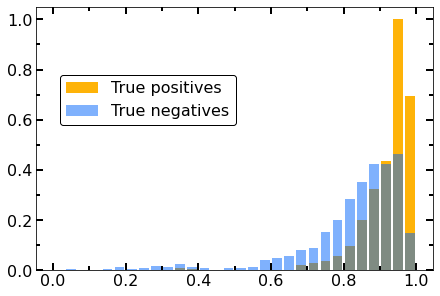

In [380]:
import matplotlib.font_manager
from matplotlib import rcParams
import matplotlib.pyplot as plt


fig, axes = plt.subplots(figsize=(6, 4), nrows=1, ncols=1,
                         constrained_layout=True, gridspec_kw={'wspace': 0.05, 'hspace': 0.1})

rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"] = "bold"
rcParams["xtick.labelsize"] = "medium"
rcParams["ytick.labelsize"] = "medium"


major_ticks_x = np.arange(0, 1.01, 0.2)
minor_ticks_x = np.arange(0, 1.01, 0.1)
major_ticks_y = np.arange(0, 1.01, 0.2)
minor_ticks_y = np.arange(0, 1.01, 0.1)

n_bins = 30


def set_ticks(ax):
    ax.tick_params(axis='both', which='both', direction="in", width=2)
    ax.tick_params(axis='both', which='major', direction="in",  length=6)
    ax.tick_params(axis='both', which='minor', length=6,
                   direction="in",  color='black')
    ax.tick_params(axis='both', which='both', bottom=True,
                  top=True, left=True, right=True, direction="in")
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)

def set_spines(ax):
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')


def set_prop(ax):
    ax.axis(aspect='equal')
    ax.set(adjustable='box')  # , aspect='equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.14)
    ax.grid(False)
    set_spines(ax)
    ax.set_facecolor('xkcd:white')
    ax.axis('on')
    set_ticks(ax)

def norm_plot(ax, x, y, alpha=1, **kwargs):
    hist, bins = np.histogram(x, **kwargs)
    hist1, _ = np.histogram(y, **kwargs)
    n_max = np.max([hist, hist1])
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax.bar(center, hist / n_max, align='center', width = width, alpha=alpha)
    set_ticks(ax)
    return hist, n_max


def lab_unlab_plot(ax, lab_d, unlab_d, n_bins):
    hist_lab, bins_lab = np.histogram(lab_d, bins=n_bins, density=True, range=(0,1))
    hist_unlab, bins_unlab = np.histogram(unlab_d, bins=n_bins, density=True, range=(0,1))
    n_max = np.max([hist_lab, hist_unlab])
    width_lab = 0.8 * (bins_lab[1] - bins_lab[0])
    width_unlab = 0.8 * (bins_unlab[1] - bins_unlab[0])
    center_lab = (bins_lab[:-1] + bins_lab[1:]) / 2
    center_unlab = (bins_unlab[:-1] + bins_unlab[1:]) / 2
    ax.bar(center_lab, hist_lab / n_max, align='center', width=width_lab, alpha=1, color='#feb308', label = 'True positives')
    ax.bar(center_unlab, hist_unlab / n_max, align='center', width=width_unlab, alpha=0.5, color='#0165fc', label = 'True negatives')
    #ax.axvline(0.9, linewidth=3, color='#980002', label = 'Threshold')
    ax.tick_params(axis='both', which='both', direction="in", width=2)
    ax.tick_params(axis='both', which='major', direction="in",  length=7)
    ax.tick_params(axis='both', which='minor', length=4,
                   direction="in",  color='black')
    ax.tick_params(axis='both', which='both', bottom=True,
                  top=True, left=True, right=True, direction="in")
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)   




lab_unlab_plot(axes, pub1[val_data_label.values.ravel()==1], pub1[val_data_label.values.ravel()==0], n_bins)
axes.legend(prop={'size': 16}, loc=(0.06, 0.55), facecolor='white', edgecolor='black', framealpha=1)#,  borderpad=1 ) #shadow=True, fancybox=True, loc=(0.75, -0.15),
#plt.savefig('/content/gnn_scores.svg')

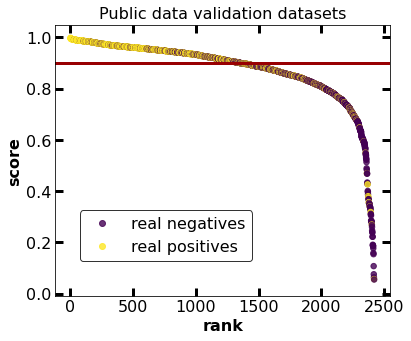

In [381]:
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
from matplotlib.lines import Line2D
fig, ax = plt.subplots(figsize=(6,5))
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
ax.set(adjustable='box')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=3)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=8)
#ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
ax.axhline(0.9, linewidth=3, color='#980002', label = 'Threshold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('score', fontsize=16)
plt.xlabel('rank', fontsize=16)


x=np.arange(len(pub))
scatter=plt.scatter(x ,pub_val_sort.score, c=pub_val_sort.color,cmap='viridis', s=30, alpha=0.8)
plt.ylim(-0.01, 1.05)
plt.title('Public data validation datasets', fontsize=16)
legend=plt.legend(handles=scatter.legend_elements()[0], labels=['real negatives', 'real positives'], loc='lower left', fontsize=16, bbox_to_anchor=(0.05, 0.1, 0.6, 1.8))
legend.get_frame().set_edgecolor('black')

#plt.savefig('/content/gnn_colorplot.svg', bbox_inches='tight' ,dpi=600)

In [232]:
# save the scaler in pickle file
import pickle
pickle.dump(X_scaler, open('/content/gnn_scaler.pkl','wb'))

In [240]:
def enable_dropout(m):
  for each_module in m.modules():
    if each_module.__class__.__name__.startswith('Dropout'):
      each_module.train()

In [241]:
deep_SVDD.ae_net.eval()
enable_dropout(deep_SVDD.ae_net)

In [242]:
def ae_score_dropout(deep_SVDD, X, labels ):
  deep_SVDD.ae_net.eval()
  enable_dropout(deep_SVDD.ae_net)
  with torch.no_grad():
    result = []
    auc=[]
    f1 = []
    mcc=[]
    for i in range(10):
      net = deep_SVDD.ae_net.to('cpu')
      X = torch.FloatTensor(X).to('cpu')
      y = net(X)
      scores = -1*nakius_score(X, y)
      result.append(scores.numpy())
      auc.append(roc_auc_score(labels, scores.numpy()))
      spearman = np.corrcoef(np.mean(result, axis=0), np.std(result, axis=0))[0][1]
      y_pred  =[1 if i>=-10 else 0 for i in scores.numpy()]
      f1.append(f1_score( labels, y_pred))
      mcc.append(matthews_corrcoef(labels, y_pred))
  return np.mean(auc, axis=0), np.std(auc, axis=0), spearman, np.mean(f1, axis=0), np.mean(mcc, axis=0)# np.mean(result, axis=0), np.std(result, axis=0)

In [243]:
from sklearn.metrics import roc_curve
def get_threshold(labels, scores):
  fpr, tpr, thresholds = roc_curve(labels, scores)
  gmeans = np.sqrt(tpr * (1 - fpr))
  ix = np.argmax(gmeans)
  thresh = thresholds[ix]
  return thresh

In [244]:
def nakius_score(y_pred, y_true):
  split_idx = y_true.shape[1]//2
  flip = y_true[:, list(range(split_idx, split_idx * 2)) + list(range(split_idx))]
  scores_1 = torch.sum((y_pred - y_true) ** 2, dim=tuple(range(1, y_pred.dim())))
  scores_2 = torch.sum((y_pred - flip) ** 2, dim=tuple(range(1, y_pred.dim())))#
  scores = torch.min(scores_1, scores_2)
  return scores

In [363]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
set_seed()
def ae_score_dropout(deep_SVDD, X, labels ):
  deep_SVDD.ae_net.eval()
  enable_dropout(deep_SVDD.ae_net)
  with torch.no_grad():
    result = []
    auc=[]
    f1 = []
    mcc=[]
    thres=[]
    for i in range(10):
      
      if i>10:
        pass
      else:
        net = deep_SVDD.ae_net.to('cpu')
        X = torch.FloatTensor(X).to('cpu')
        y = net(X)
        scores = -1*bidirectional_score(X, y)
        X_scaler = MinMaxScaler()
        lab = -1*ae_score(deep_SVDD, df_train.iloc[:,:].values).cpu().detach().numpy() #
        lab = lab.clip(-32,0)
        lab1 = X_scaler.fit_transform(lab.reshape(-1,1))
        scores=X_scaler.transform(scores.reshape(-1, 1)).ravel()
        result.append(scores)
      
        auc.append(roc_auc_score(labels, scores))
        spearman = np.corrcoef(np.mean(result, axis=0), np.std(result, axis=0))[0][1]
        threshold = 0.90# get_threshold(labels, scores)
        y_pred  =[1 if i>=threshold else 0 for i in scores]
        f1.append(f1_score( labels, y_pred))
        mcc.append(matthews_corrcoef(labels, y_pred))
        thres.append(threshold)
  print(np.mean(thres))
  return np.mean(result, axis=0), np.std(result, axis=0) , np.mean(auc, axis=0), np.std(auc, axis=0), np.mean(f1, axis=0),np.std(f1, axis=0)

In [364]:
scores, std, auc_mean, auc_std , f1, f1_std = ae_score_dropout(deep_SVDD, validation_set.values, val_label)#.cpu().detach().numpy()
auc_mean

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.9


0.7567341403423237

In [333]:
print('f1', round(f1, 2))
print('f1_std', round(f1_std, 3))

print('auc', round(auc_mean, 2))
print('auc_std', round(auc_std, 4))

f1 0.73
f1_std 0.003
auc 0.76
auc_std 0.0003


In [385]:
threshold = 0.91
ind1=(val_label.values.ravel()==1) & (scores< threshold) #FN
ind2=(val_label.values.ravel()==1) & (scores> threshold) #TP
ind3=(val_label.values.ravel()==0) & (scores> threshold) #FP
ind4=(val_label.values.ravel()==0) & (scores< threshold) #TN

In [386]:
print(np.mean(std[ind1])) #FP
np.std(std[ind1])

0.008144238347782821


0.010147394622108728

In [387]:
print(np.mean(std[ind2])) #TP
np.std(std[ind2])

0.003365808519696087


0.002481049192105235

In [388]:
print(np.mean(std[ind3])) #FN
np.std(std[ind3])

0.003599453141145604


0.0022859718897900896

In [389]:
print(np.mean(std[ind4])) #TN
np.std(std[ind4])

0.009588469479667688


0.00749996564986197

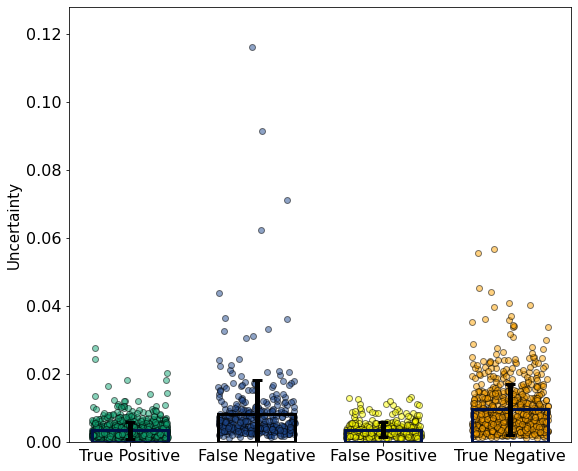

In [408]:
import matplotlib.pyplot as plt
np.random.seed(123)

w = 0.6   # bar width
x = [1, 2, 3, 4] # x-coordinates of your bars
colors = ['#10a674', '#1e488f', 'yellow', 'orange']
colors1 = ['#001146', 'black','#001146','#001146']
y = [std[ind2],    
    std[ind1],std[ind3], std[ind4]]

fig, ax = plt.subplots(figsize=(9, 8))
ax.bar(x,
       height=[np.mean(yi) for yi in y],
       yerr=[np.std(yi) for yi in y],    # error bars
       capsize=12, # error bar cap width in points
       width=w,    # bar width
       tick_label=["True Positive", "False Negative", "False Positive", 'True Negative'],
       color=(0,0,0,0),  # face color transparent
       #edgecolor='black',
       linewidth=3,
       edgecolor=colors1,    # error bar colors; setting this raises an error for whatever reason.
      error_kw=dict(lw=5, capsize=5, capthick=3))

for i in range(len(x)):
    # distribute scatter randomly across whole width of bar
    ax.scatter(x[i] + np.random.random(y[i].size) * w - w / 2, y[i], color=colors[i], edgecolor='black', alpha=0.5)
plt.ylim(0,0.128)
plt.ylabel('Uncertainty', fontsize=15)
#plt.savefig('/content/fig1.svg')
plt.show()

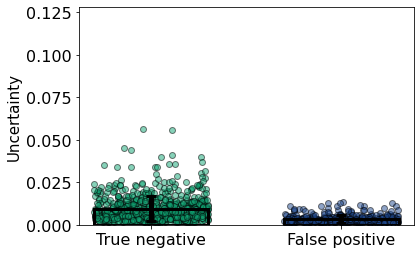

In [406]:
import matplotlib.pyplot as plt
np.random.seed(123)

w = 0.6   # bar width
x = [1, 2] # x-coordinates of your bars
colors = ['#10a674', '#1e488f']#[(0, 0, 1, 1), (1, 0, 0, 1)]    # corresponding colors
colors1 = ['black', 'black']#
y = [std[ind4],       # data series
    std[ind3]]

fig, ax = plt.subplots()
ax.bar(x,
       height=[np.mean(yi) for yi in y],
       yerr=[np.std(yi) for yi in y],    # error bars
       capsize=12, # error bar cap width in points
       width=w,    # bar width
       tick_label=["True negative", "False positive"],
       color=(0,0,0,0),  # face color transparent
       #edgecolor='black',
       linewidth=3,
       edgecolor=colors1,    # error bar colors; setting this raises an error for whatever reason.
      error_kw=dict(lw=5, capsize=5, capthick=3))

for i in range(len(x)):
    # distribute scatter randomly across whole width of bar
    ax.scatter(x[i] + np.random.random(y[i].size) * w - w / 2, y[i], color=colors[i], edgecolor='black', alpha=0.5)
plt.ylim(0,0.128)
plt.ylabel('Uncertainty', fontsize=15)
#plt.savefig('/content/panel1.svg')
plt.show()

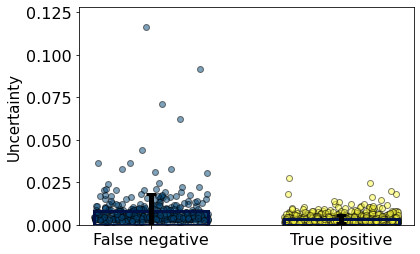

In [412]:
import matplotlib.pyplot as plt
np.random.seed(123)

w = 0.6   # bar width
x = [1, 2] # x-coordinates of your bars
colors = ['#004577', '#fffe40']#[(0, 0, 1, 1), (1, 0, 0, 1)]    # corresponding colors
colors1 = ['#001146', '#001146']#
y = [std[ind1],       # data series
    std[ind2]]

fig, ax = plt.subplots()
ax.bar(x,
       height=[np.mean(yi) for yi in y],
       yerr=[np.std(yi) for yi in y],    # error bars
       capsize=12, # error bar cap width in points
       width=w,    # bar width
       tick_label=["False negative", "True positive"],
       color=(0,0,0,0),  # face color transparent
       #edgecolor='black',
       linewidth=3,
       edgecolor=colors1,    # error bar colors; setting this raises an error for whatever reason.
      error_kw=dict(lw=5, capsize=5, capthick=3))

for i in range(len(x)):
    # distribute scatter randomly across whole width of bar
    ax.scatter(x[i] + np.random.random(y[i].size) * w - w / 2, y[i], color=colors[i], edgecolor='black', alpha=0.5)
plt.ylim(0,0.128)
plt.ylabel('Uncertainty', fontsize=15)
#plt.savefig('/content/panel2.svg')
plt.show()

In [393]:
#pd.DataFrame(scores, columns=['scores'])

dataki=pd.concat([validation_data, pd.DataFrame(std, columns=['scores']), pd.DataFrame(std, columns=['std'])], axis=1)
#dataki[dataki.smiles1 == 'CCC(C)N1N=CN(C1=O)C1=CC=C(C=C1)N1CCN(CC1)C1=CC=C(OCC2COC(CN3C=NC=N3)(O2)C2=C(Cl)C=C(Cl)C=C2)C=C1']
da=dataki[dataki.scores >= 0.04]
da#[da['Co-crystal'] == 0]#.shape

,Co-crystal,Dataset,year,name1,smiles1,name2,smiles2,scores,std
7,0,artemisin,2014,QNGHSU02,CC1CCC2C(C)C(=O)OC3OC4(C)CCC1C23OO4,"3,5-Diaminobenzoic Acid",NC1=CC(=CC(=C1)N)C(O)=O,0.055536,0.055536
25,0,artemisin,2014,QNGHSU02,CC1CCC2C(C)C(=O)OC3OC4(C)CCC1C23OO4,methylglucosamine,CNCC(O)C(O)C(O)C(O)CO,0.044072,0.044072
36,0,artemisin,2014,QNGHSU02,CC1CCC2C(C)C(=O)OC3OC4(C)CCC1C23OO4,sorbitol,OCC(O)C(O)C(O)C(O)CO,0.056668,0.056668
1124,0,H-bond synthons dataset,2017,L-Ascorbic Acid,OCC(O)C1OC(=O)C(=C1O)O,4-Hydroxybenzoic Acid,c1cc(ccc1C(=O)O)O,0.040940,0.040940
1425,1,Phenolic acids,2018,maleimide,O=C1NC(=O)C=C1,"3,4,5-trihydroxybenzoic acid",OC(=O)C1=CC(=C(O)C(=C1)O)O,0.091545,0.091545
1427,1,Phenolic acids,2018,maleimide,O=C1NC(=O)C=C1,"3,5-dihydroxybenzoic acid",OC(=O)C1=CC(=CC(=C1)O)O,0.116198,0.116198
1521,0,Dicarboxylic acids,2019,adipicacid,OC(=O)CCCCC(O)=O,heptanedioicacid,OC(=O)CCCCCC(O)=O,0.040180,0.040180
1664,1,Dicarboxylic acids,2019,"2,2'-biimidazole",c1c[nH]c(n1)c1ncc[nH]1,succinicacid,OC(=O)CCC(O)=O,0.062442,0.062442
1945,1,Dicarboxylic acids,2019,4-aminobutyricacid,NCCCC(O)=O,ethanedioicacid,OC(=O)C(O)=O,0.043790,0.043790
2238,1,(des)loratadine,2020,loratadine,CCOC(=O)N1CCC(CC1)=C1C2=C(CCC3=C1N=CC=C3)C=C(C...,Mannitol,OCC(O)C(O)C(O)C(O)CO,0.071227,0.071227


# Wandbi

In [413]:
# WandB – Install the W&B library
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

In [414]:
sweep_config = {
    'method': 'bayes',
    'metric': {
      'name': 'loss',
      'goal': 'minimize'   
    },
    'parameters': {
        'n_epochs': {
            'values': [10, 50, 100]
        },
        'batch_size': {
            'values': [256, 128, 64, 32]

        },
        'weight_decay': { 
            'values': [1e-3, 1e-4, 1e-5, 1e-6]
        },
        'lr': {
            'values': [1e-2, 1e-3, 1e-4, 3e-4, 1e-5]
        },
        'optimizer_name': {
            'values': ['adam']
        }

        }
    }

In [415]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
sweep_id = wandb.sweep(sweep_config, entity="kvriza", project="gnn_optimize")

Create sweep with ID: rifcvn9e
Sweep URL: https://wandb.ai/kvriza/gnn_optimize/sweeps/rifcvn9e


In [416]:
def train():
      # Random starting values for hyper-parameters we're going to sweep over
  config_defaults = {
        'n_epochs': 50,
        'batch_size': 32,
        'weight_decay': 1e-04,
        'lr': 1e-4,
        'optimizer_name': 'adam',
    }
  wandb.init(config=config_defaults)
  config = wandb.config
  deep_SVDD.pretrain(dataset,
                   optimizer_name=cfg.settings['ae_optimizer_name'],
                   lr=config.lr,
                   n_epochs = config.n_epochs ,
                   lr_milestones=(100,),
                   batch_size= config.batch_size , 
                   weight_decay= config.weight_decay ,
                   device=device,
                   n_jobs_dataloader=0, use_wandb=True)
  wandb.log({"auc": deep_SVDD.ae_trainer.test(dataset, deep_SVDD.ae_net)}) 

In [ ]:
wandb.agent(sweep_id, train)

INFO:wandb.agents.pyagent:Starting sweep agent: entity=None, project=None, count=None
wandb: Agent Starting Run: 9r6nt6rp with config:
wandb: 	batch_size: 32
wandb: 	lr: 0.0003
wandb: 	n_epochs: 50
wandb: 	optimizer_name: adam
wandb: 	weight_decay: 1e-06
wandb: Currently logged in as: kvriza. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
INFO:root:Starting pretraining...
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/50	 Time: 6.114	 Loss: 23.08130542
INFO:root:  Epoch 2/50	 Time: 5.306	 Loss: 15.45420914
INFO:root:  Epoch 3/50	 Time: 5.297	 Loss: 12.84314116
INFO:root:  E